# **Time Series - Statistical Models (AR,MA,ARIMA)**

### ***Import Libraries and Dataset***

In [280]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

from sklearn.metrics import mean_squared_error

In [281]:
unrate = pd.read_csv('UNRATE.csv')

In [282]:
unrate.head(2)

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8


### ***Cleaning***

***Datatype and Index handling***

In [283]:
unrate['DATE'] = pd.to_datetime(unrate['DATE'],format='%Y-%m-%d')

In [284]:
unrate['UNRATE'] = pd.to_numeric(unrate['UNRATE'], errors='coerce')

In [285]:
# Setting Date as the Index
unrate.set_index('DATE', inplace=True)
unrate.tail(2)

,UNRATE
DATE,
2024-02-01,3.9
2024-03-01,3.8


***Checking for null values***

In [286]:
null_counts = unrate.isnull().sum()
null_counts

UNRATE    0
dtype: int64

### ***Plots***

***1. Overall Trend***

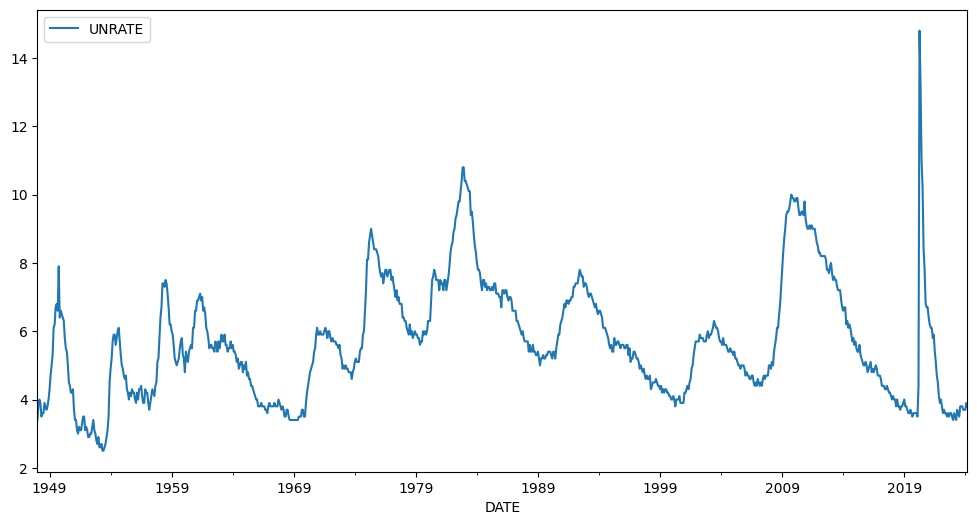

In [287]:
unrate.plot(figsize=(12,6))
plt.show()

***2. Rolling Unemployment Rate weekly per year***

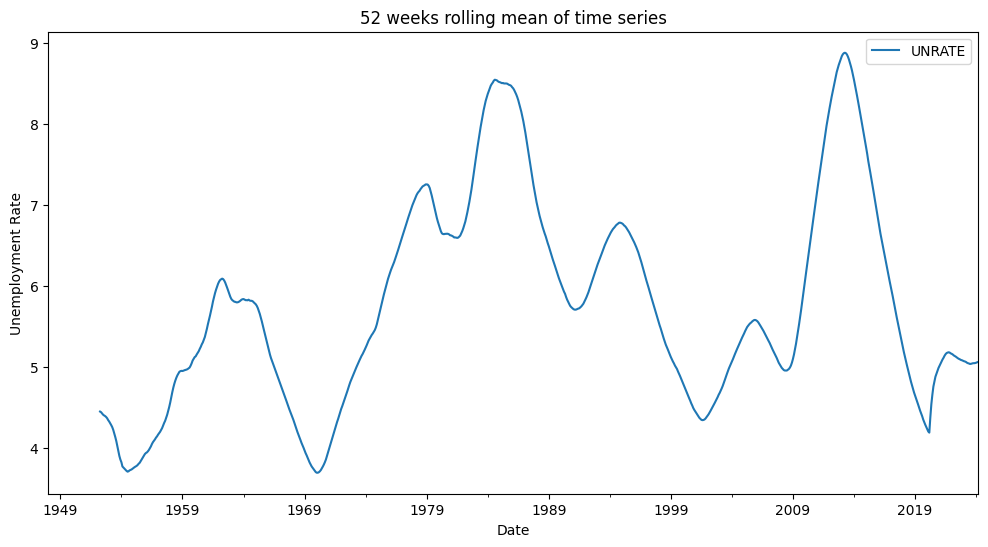

In [288]:
unrate_mean = unrate.rolling(window=52).mean()
ax = unrate_mean.plot(figsize=(12,6))
ax.set_xlabel("Date")
ax.set_ylabel("Unemployment Rate")
ax.set_title("52 weeks rolling mean of time series")
plt.show()

***3. Rolling Unemployment Rate weekly per year***

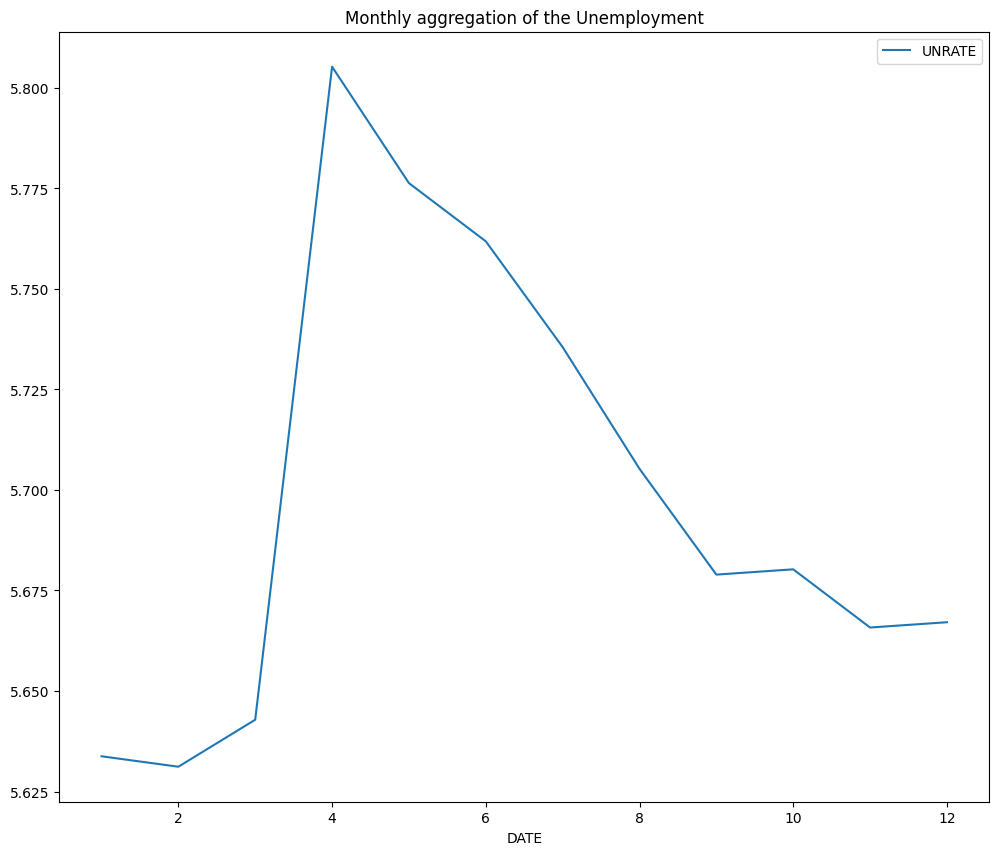

In [289]:
index_month = unrate.index.month
unrate_by_month = unrate.groupby(index_month).mean()
unrate_by_month.plot(figsize=(12,10))
plt.title('Monthly aggregation of the Unemployment')
plt.show()

### ***Stationarity Check***

#### 1. **Augmented Dickey Fuller Test**

The Augmented Dickey-Fuller (ADF) test is a statistical test commonly used in time series analysis to determine whether a given time series is stationary or not

**Null Hypothesis**: The null hypothesis of the ADF test is that the time series has a unit root, indicating that it is non-stationary. In other words, if the null hypothesis cannot be rejected, it suggests that the time series is non-stationary and exhibits a unit root, implying a linear trend or dependence on past values.

**Alternate Hypothesis**: The alternative hypothesis of the ADF test is that the time series is stationary, meaning it does not have a unit root. Rejecting the null hypothesis in favor of the alternative hypothesis indicates that the time series is likely stationary.

In [290]:
from statsmodels.tsa.stattools import adfuller,kpss

result = adfuller(unrate['UNRATE'])

# Print the ADF test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the ADF test results
if result[1] < 0.05:
    print("\nThe time series is likely stationary (reject the null hypothesis of non-stationarity).")
else:
    print("\nThe time series is likely non-stationary (fail to reject the null hypothesis of non-stationarity).")

ADF Statistic: -3.8920186799196363
p-value: 0.0020943767430912814
Critical Values:
   1%: -3.4375326734225844
   5%: -2.8647108493902986
   10%: -2.568458364370556

The time series is likely stationary (reject the null hypothesis of non-stationarity).


#### 2. **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**


The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is another statistical test used in time series analysis to assess the stationarity of a time series data. Unlike the Augmented Dickey-Fuller (ADF) test, which tests for the presence of a unit root (indicating non-stationarity), the KPSS test evaluates the null hypothesis of stationarity against the alternative hypothesis of non-stationarity around a deterministic trend.

**Null Hypothesis**: The null hypothesis of the KPSS test is that the time series is stationary around a deterministic trend. In other words, the null hypothesis assumes that the time series is stationary, except for possible trend components.

**Alternate Hypothesis**: The alternative hypothesis of the KPSS test is that the time series has a unit root or is non-stationary around a deterministic trend. Rejecting the null hypothesis in favor of the alternative hypothesis suggests non-stationarity.

In [291]:
# Perform the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity
kpss_result = kpss(unrate['UNRATE'])
print('\nKPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'   {key}: {value}')
if kpss_result[1] < 0.05:
    print("\nThe time series is likely non-stationary (reject the null hypothesis of stationarity based on KPSS test).")
else:
    print("\nThe time series is likely stationary (fail to reject the null hypothesis of stationarity based on KPSS test).")


KPSS Statistic: 0.44389489198493187
p-value: 0.05823496035132248
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739

The time series is likely stationary (fail to reject the null hypothesis of stationarity based on KPSS test).


### ***Checking for Trend, Seasonality and Noise***

#### 1. **Trend**

*   **Significance**: The trend component represents the long-term movement or direction of the time series data. It captures the overall pattern of growth, decline, or stability in the data over an extended period.
*   **Importance**: Identifying and modeling the trend is crucial for
making predictions about the future behavior of the time series. It helps in understanding whether the data is exhibiting a consistent upward or downward movement, or if it is relatively stable over time.







#### 2.   **Seasonal**

*   **Significance**: Seasonality refers to repetitive patterns or fluctuations in the data that occur at regular intervals, such as daily, weekly, monthly, or yearly cycles. These patterns are often driven by external factors like weather, holidays, or seasonal events.
*   **Importance**: Identifying seasonality helps in understanding the cyclic behavior of the time series data and its impact on the overall trend. Seasonal adjustments are necessary to remove these cyclic patterns and isolate the underlying trend and noise components for accurate analysis and forecasting.

#### 3.   **Noise**


*   **Significance**: Noise, also known as residuals or irregular components, represents the random fluctuations or variability in the data that cannot be explained by the trend or seasonal patterns. It includes unpredictable factors, measurement errors, or random shocks.
*   **Importance**: Understanding and modeling the noise component are essential for assessing the goodness of fit of a time series model and evaluating its predictive performance. Minimizing noise improves the accuracy of forecasts and enhances the reliability of insights derived from the data.

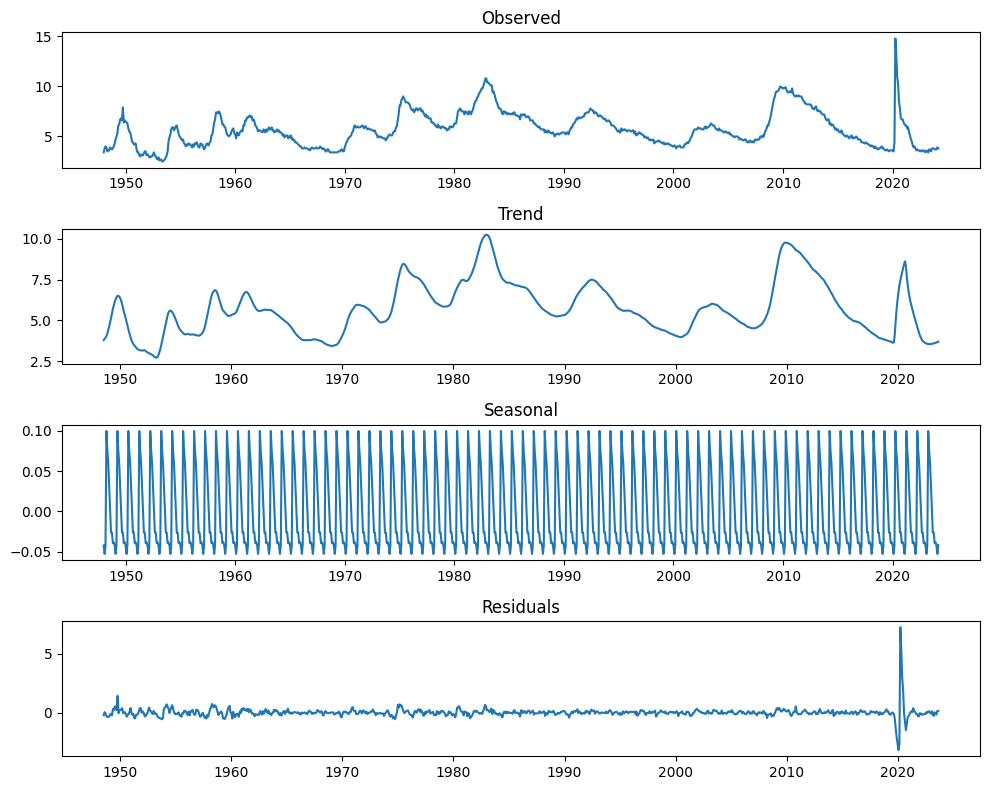

In [292]:
# Perform seasonal decomposition
result = seasonal_decompose(unrate['UNRATE'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

In [293]:
!pip install pmdarima

## ***Pre-processing***

In [294]:
pred_periods = 39
split_number = unrate['UNRATE'].count() - pred_periods
df_train = pd.DataFrame(unrate['UNRATE'][:split_number]).rename(columns={'UNRATE':'y_train'})
df_test = pd.DataFrame(unrate['UNRATE'][split_number:]).rename(columns={'UNRATE':'y_test'})

<Figure size 1000x600 with 0 Axes>

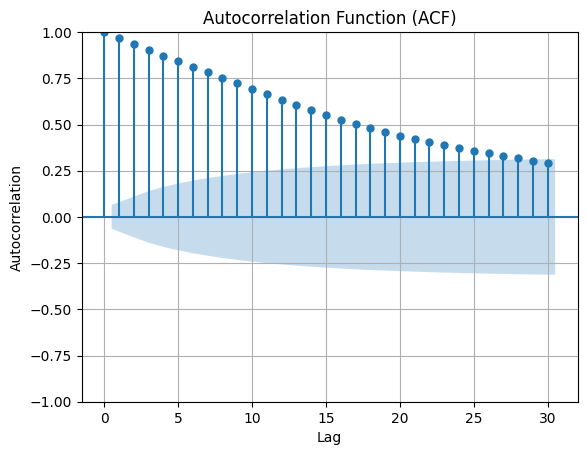

<Figure size 1000x600 with 0 Axes>

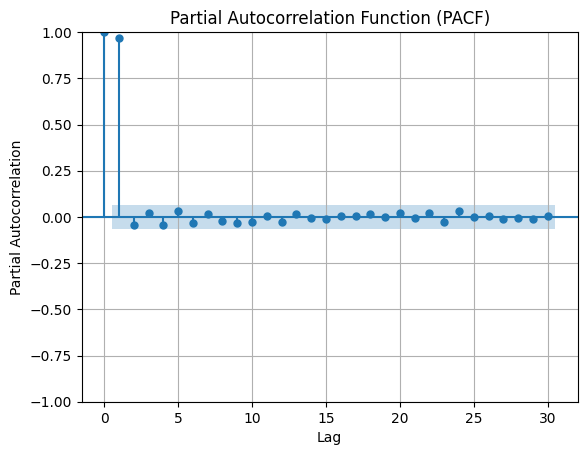

In [295]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(10, 6))
plot_acf(unrate['UNRATE'], lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plt.figure(figsize=(10, 6))
plot_pacf(unrate['UNRATE'], lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

From the PACF and ACF plots, it is clear that ideal value for p is 2 and q is 1

## ***Models***

### ***1. AR Model***

An **Autoregressive (AR) model** is a type of time series model used in statistics and econometrics to understand and predict future values based on past observations. Here's a brief overview of AR models:


The autoregressive (AR) model equation is given by:
\begin{align*}
&  Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} + \varepsilon_t
\end{align*}
where:
\begin{align*}
& Y_t \text{ is the value of the time series at time } t, \\
& c \text{ is a constant,} \\
& \phi_1, \phi_2, \ldots, \phi_p \text{ are parameters,} \\
& Y_{t-1}, Y_{t-2}, \ldots, Y_{t-p} \text{ are lagged values of the time series,} \\
& \varepsilon_t \text{ is white noise representing random fluctuations or errors.}
\end{align*}



#### **Model fiting**

In [296]:
# Fit AR model
order = (2, 0, 0)
model = ARIMA(df_train, order=order)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### **Prediction and Evaluation**

In [297]:
# Forecast using AR model
forecast = model_fit.forecast(steps=len(df_test))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_test, forecast))

print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 2.204044291144757


#### **Plotting to compare the predictions with true value for testing data**

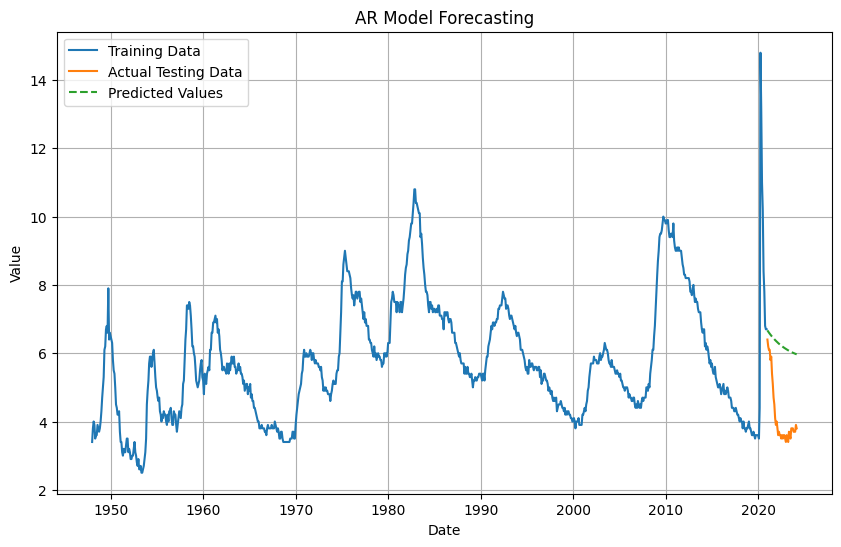

In [298]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train['y_train'], label='Training Data')
plt.plot(df_test.index, df_test['y_test'], label='Actual Testing Data')
plt.plot(df_test.index, forecast, label='Predicted Values', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('AR Model Forecasting')
plt.legend()
plt.grid(True)
plt.show()

### ***2. MA Model***

A **Moving Average (MA)** model is a type of time series model used to understand and predict future values based on the average of past forecast errors. Unlike Autoregressive (AR) models that depend on past values of the series, MA models depend on past forecast errors.


The Moving Average (MA) model equation is given by:

\begin{align*}
 Y_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q}
\end{align*}
where:
\begin{align*}
& Y_t \text{ is the value of the time series at time } t, \\
& c \text{ is a constant,} \\
& \varepsilon_t \text{ is the white noise error term at time } t, \\
& \theta_1, \theta_2, \ldots, \theta_q \text{ are parameters,} \\
& \varepsilon_{t-1}, \varepsilon_{t-2}, \ldots, \varepsilon_{t-q} \text{ are lagged forecast errors.}
\end{align*}



#### **Model fiting**

In [299]:
# Fit MA model
order = (0, 0, 1)  # MA(q), set q=1 for MA(1) model
model = ARIMA(df_train, order=order)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


#### **Prediction and Evaluation**

In [300]:
# Forecast using MA model
forecast = model_fit.forecast(steps=len(df_test))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_test, forecast))

print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1.8430700055055949


#### **Plotting to compare the predictions with true value for testing data**

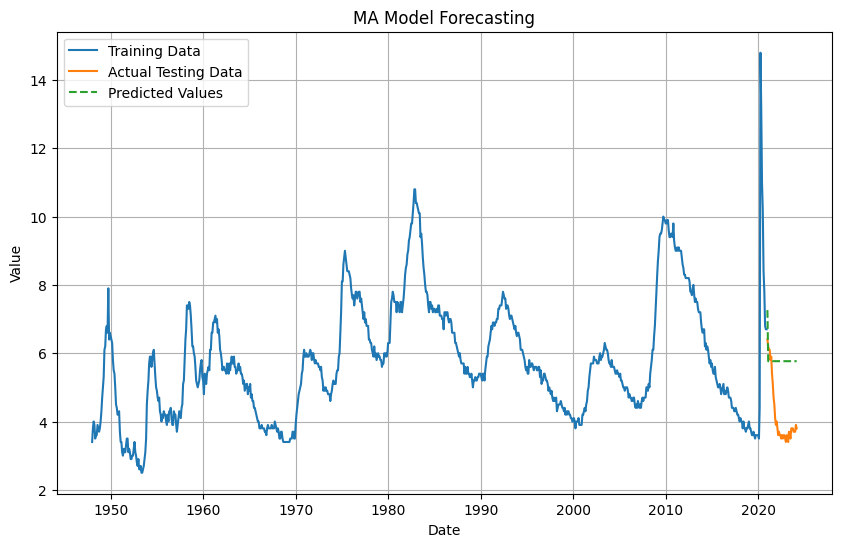

In [301]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train['y_train'], label='Training Data')
plt.plot(df_test.index, df_test['y_test'], label='Actual Testing Data')
plt.plot(df_test.index, forecast, label='Predicted Values', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('MA Model Forecasting')
plt.legend()
plt.grid(True)
plt.show()

### ***3. ARIMA Model***

ARIMA stands for **Autoregressive Integrated Moving Average**. It's a popular time series analysis and forecasting method that combines Autoregressive (AR) and Moving Average (MA) components with differencing to handle non-stationary data.

The **AR** part models the relationship between the current observation and its lagged (past) observations. It depends on the lag order p, which indicates how many past observations are considered.

The **I** part involves differencing the series to make it stationary. It is denoted by the differencing order d.

The **MA** part models the dependency between the current observation and a linear combination of past forecast errors. It depends on the lag order q, indicating how many past forecast errors are considered.


The ARIMA(p, d, q) model equation is given by:
\begin{align*}
 Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q} + \varepsilon_t
\end{align*}
where:
\begin{align*}
& Y_t \text{ is the value of the time series at time } t, \\
& c \text{ is a constant,} \\
& \phi_1, \phi_2, \ldots, \phi_p \text{ are autoregressive parameters,} \\
& Y_{t-1}, Y_{t-2}, \ldots, Y_{t-p} \text{ are lagged values of the time series,} \\
& \theta_1, \theta_2, \ldots, \theta_q \text{ are moving average parameters,} \\
& \varepsilon_t \text{ is the white noise error term at time } t, \\
& \varepsilon_{t-1}, \varepsilon_{t-2}, \ldots, \varepsilon_{t-q} \text{ are lagged forecast errors.}
\end{align*}



#### **Model fiting**

In [302]:
model_fit = pm.auto_arima(df_train, test='adf',
                         max_p=3, max_d=3, max_q=3,
                         seasonal=True, m=12,
                         max_P=3, max_D=2, max_Q=3,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3424.669, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=985.294, Time=2.51 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2162.907, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5630.990, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=986.721, Time=0.18 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=984.119, Time=8.77 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=983.359, Time=23.55 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=26.38 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=13.68 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=2890.960, Time=17.88 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=1004.216, Time=30.80 sec
 ARIMA(1,0,1)(3,0,0)[12] intercept   : AIC=985.407, Time=25.83 sec
 ARIMA(0,0,1)(3,0,0)[12] intercept   : AIC=2063.533, Time=19.86 sec
 ARIMA(2,0,1)(3,0,0)[12] interce

In [303]:
print(model_fit.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  876
Model:             SARIMAX(2, 0, 1)x(3, 0, [], 12)   Log Likelihood                -483.394
Date:                             Fri, 19 Apr 2024   AIC                            982.787
Time:                                     18:01:09   BIC                           1020.990
Sample:                                 01-01-1948   HQIC                           997.400
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3340      0.151      2.215      0.027       0.038       0.630
ar.L1          0.0185      

#### **Prediction and Evaluation**

In [304]:
forecast = model_fit.predict(n_periods=pred_periods)

rmse = np.sqrt(mean_squared_error(df_test['y_test'], forecast))

print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1.8480480105687047


#### **Plotting to compare the predictions with true value for testing data**

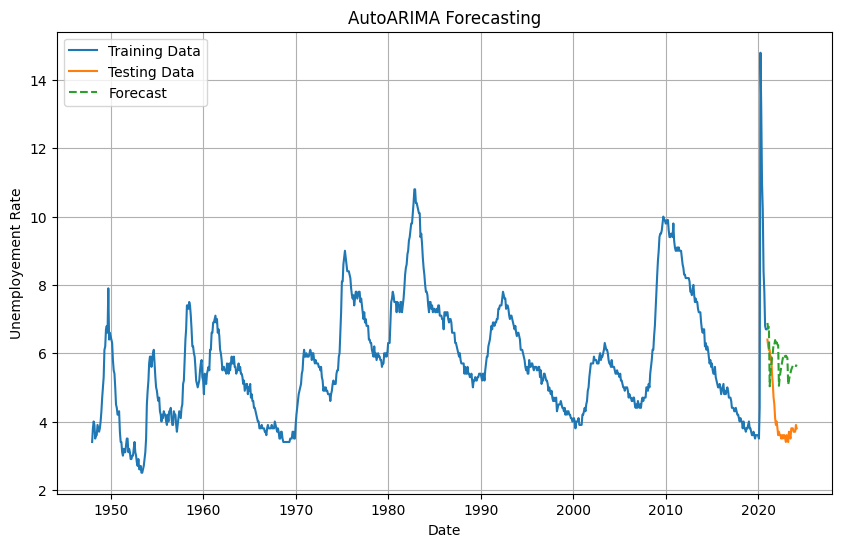

In [305]:
# Predict next 15 periods
forecast = model_fit.predict(n_periods=pred_periods)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train['y_train'], label='Training Data')
plt.plot(df_test.index, df_test['y_test'], label='Testing Data')
plt.plot(df_test.index, forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Unemployement Rate')
plt.title('AutoARIMA Forecasting')
plt.legend()
plt.grid(True)
plt.show()


## ***Future Forecasting for next 2 years (Till 2026 end)***

In [306]:
order = (2, 0, 1)  # Replace p, d, q with appropriate values for your ARIMA model
model = ARIMA(unrate['UNRATE'], order=order)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [307]:
# Forecast for future periods
pred_periods = 33  # Number of periods to forecast into the future
last_date = unrate.index[-1]  # Get the last date in the test data
forecast_index = pd.date_range(start=last_date, periods=pred_periods+1, freq='MS')[1:]  # Extend the index for forecast by month

forecast = model_fit.forecast(steps=pred_periods)  # Predict for the future periods

# Print the forecast for the specified number of periods
print("Forecasted values for the next", pred_periods, "periods:")
print(forecast)

Forecasted values for the next 33 periods:
2024-04-01    3.830786
2024-05-01    3.903680
2024-06-01    3.941426
2024-07-01    4.003071
2024-08-01    4.043649
2024-09-01    4.097560
2024-10-01    4.138641
2024-11-01    4.186939
2024-12-01    4.227237
2025-01-01    4.271226
2025-02-01    4.310059
2025-03-01    4.350561
2025-04-01    4.387594
2025-05-01    4.425148
2025-06-01    4.460245
2025-07-01    4.495222
2025-08-01    4.528358
2025-09-01    4.561026
2025-10-01    4.592237
2025-11-01    4.622804
2025-12-01    4.652160
2026-01-01    4.680791
2026-02-01    4.708379
2026-03-01    4.735215
2026-04-01    4.761126
2026-05-01    4.786292
2026-06-01    4.810620
2026-07-01    4.834225
2026-08-01    4.857062
2026-09-01    4.879206
2026-10-01    4.900641
2026-11-01    4.921418
2026-12-01    4.941534
Freq: MS, Name: predicted_mean, dtype: float64


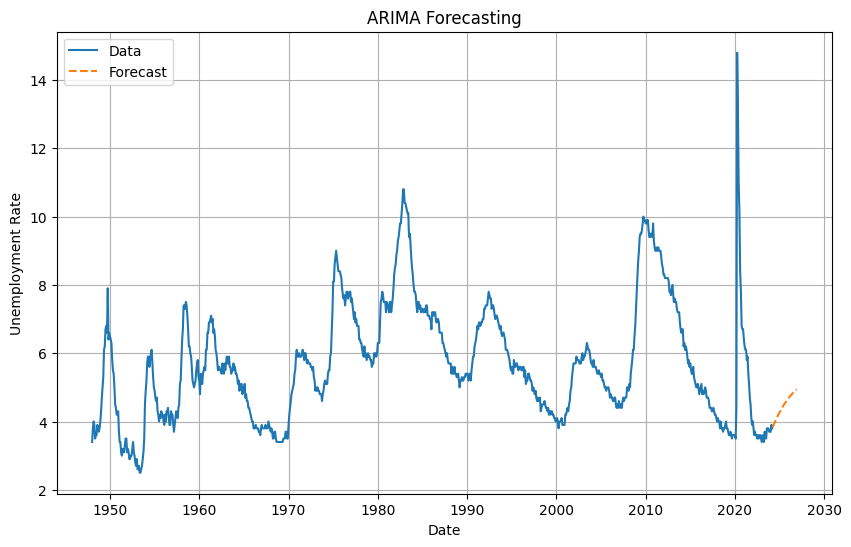

In [308]:

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(unrate.index, unrate['UNRATE'], label='Data')
plt.plot(forecast_index, forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.title('ARIMA Forecasting')
plt.legend()
plt.grid(True)
plt.show()

In [309]:
forecast_index

DatetimeIndex(['2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01',
               '2025-08-01', '2025-09-01', '2025-10-01', '2025-11-01',
               '2025-12-01', '2026-01-01', '2026-02-01', '2026-03-01',
               '2026-04-01', '2026-05-01', '2026-06-01', '2026-07-01',
               '2026-08-01', '2026-09-01', '2026-10-01', '2026-11-01',
               '2026-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [310]:
forecast

2024-04-01    3.830786
2024-05-01    3.903680
2024-06-01    3.941426
2024-07-01    4.003071
2024-08-01    4.043649
2024-09-01    4.097560
2024-10-01    4.138641
2024-11-01    4.186939
2024-12-01    4.227237
2025-01-01    4.271226
2025-02-01    4.310059
2025-03-01    4.350561
2025-04-01    4.387594
2025-05-01    4.425148
2025-06-01    4.460245
2025-07-01    4.495222
2025-08-01    4.528358
2025-09-01    4.561026
2025-10-01    4.592237
2025-11-01    4.622804
2025-12-01    4.652160
2026-01-01    4.680791
2026-02-01    4.708379
2026-03-01    4.735215
2026-04-01    4.761126
2026-05-01    4.786292
2026-06-01    4.810620
2026-07-01    4.834225
2026-08-01    4.857062
2026-09-01    4.879206
2026-10-01    4.900641
2026-11-01    4.921418
2026-12-01    4.941534
Freq: MS, Name: predicted_mean, dtype: float64

## ***Conclusion***

---------------------------------------------
| Model  | RMSE (Root Mean Squared Error)   |
---------------------------------------------
|   ARIMA  | 1.8480                            |
---------------------------------------------
| MA     | 1.8431                            |
---------------------------------------------
| AR     | 2.2040                            |
---------------------------------------------
